#### Cleaning data and filtering the covid period

In [1]:
import pandas as pd
import numpy as np
import rolling_hrp as rol
import HRP
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("data/ibrx_mensal.xlsx", na_values="-")

# transforming the 'Data' column to a date format
df['Data'] = df['Data'].str.replace('Jan', '01').str.replace('Fev', '02').str.replace('Mar', '03').str.replace('Abr', '04').str.replace('Mai', '05').str.replace('Jun', '06').str.replace('Jul', '07').str.replace('Ago', '08').str.replace('Set', '09').str.replace('Out', '10').str.replace('Nov', '11').str.replace('Dez', '12')
    
def filter_covid(df):
    
    df['Data'] = pd.to_datetime(df['Data'], format='%m-%Y')
    df_covid = df[(df['Data'] >= '2000-01-01') & (df['Data'] <= '2022-06-01')].dropna(axis=1) # dataframe with covid period include
    df_w_covid = df[(df['Data'] >= '2000-01-01') & (df['Data'] <= '2020-02-01')].dropna(axis=1) # dataframe with covid period excluded

    return [df_covid, df_w_covid]


data = filter_covid(df)

#### Applying HRP strategies to the data

In [2]:
def apply_rolling_hrp(df, window_length):
    df_result = df.iloc[:, 1:] # skipping the 'Data' column
    df_result = rol.rolling_window_HRP(df_result, window_length)
    df_result = df_result.reset_index(drop=True)
    df_result['Date'] = df['Data'].reset_index(drop=True)
    return df_result

def apply_hrp(lst):
    df_covid, df_w_covid = lst
    results_60c = apply_rolling_hrp(df_covid, 60)
    results_120c = apply_rolling_hrp(df_covid, 120)
    results_60 = apply_rolling_hrp(df_w_covid, 60)
    results_120 = apply_rolling_hrp(df_w_covid, 120)
    return [results_60c, results_120c, results_60, results_120]

data_hrp = apply_hrp(data)
data_hrp

c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)
c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)
c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)
c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distan

[          Date  Equal Weights        HRP         MV
 0   2000-01-01      -5.999268  -4.994623  -8.396179
 1   2000-02-01      15.019031  13.874689  14.817926
 2   2000-03-01      -6.380284  -7.403602  -5.429452
 3   2000-04-01      -6.549963  -9.712360 -19.441430
 4   2000-05-01       3.881629   2.924667   4.257075
 ..         ...            ...        ...        ...
 205 2017-02-01      -1.652292   0.448585  12.982208
 206 2017-03-01       5.879145   6.097339  12.537133
 207 2017-04-01      -5.814921  -4.902861  -5.778758
 208 2017-05-01       4.785115   2.607822  -3.600660
 209 2017-06-01     -11.232585 -10.157473  -7.850752
 
 [210 rows x 4 columns],
           Date  Equal Weights       HRP        MV
 0   2000-01-01      -2.882625 -2.872329 -0.749151
 1   2000-02-01      -0.228344 -0.342668 -3.188452
 2   2000-03-01       4.792239  3.412342 -1.389152
 3   2000-04-01      -2.560399 -1.488646  2.485828
 4   2000-05-01      -6.137683 -5.794305  1.258568
 ..         ...            ... 

#### Adding descriptive statistics and concatenating the data to each strategy

In [3]:
stats = pd.DataFrame() # Create an empty dataframe to store the results
df_names = ["60c", "120c", "60", "120"]
for i, j in enumerate(data_hrp):
    temp_stats = j.describe(percentiles=[0.25, 0.5, 0.75])
    temp_stats.loc['std'] = j.std() # Add standard deviation
    temp_stats.loc['skewness'] = j.skew() # Add skewness
    temp_stats.loc['kurtosis'] = j.kurtosis() # Add kurtosis
    col_prefix = df_names[i] + "_" # Add prefix based on the original dataframe name
    temp_stats.columns = [col_prefix + col for col in temp_stats.columns] # Add prefix to column names
    stats = pd.concat([stats, temp_stats], axis=1) # Concatenate the results for each dataframe horizontally with the previous results

stats

C:\Users\felip\AppData\Local\Temp\ipykernel_21748\982723506.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_stats.loc['skewness'] = j.skew() # Add skewness
C:\Users\felip\AppData\Local\Temp\ipykernel_21748\982723506.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_stats.loc['kurtosis'] = j.kurtosis() # Add kurtosis
C:\Users\felip\AppData\Local\Temp\ipykernel_21748\982723506.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_stats.loc['skewness'] = j.skew() # Add 

,60c_Equal Weights,60c_HRP,60c_MV,120c_Equal Weights,120c_HRP,120c_MV,60_Equal Weights,60_HRP,60_MV,120_Equal Weights,120_HRP,120_MV
count,210.000000,210.000000,210.000000,150.000000,150.000000,150.000000,182.000000,182.000000,182.000000,122.000000,122.000000,122.000000
mean,1.386803,1.099114,0.641974,1.115823,0.961312,0.497187,1.421027,1.157554,0.715305,1.104687,1.039013,0.659720
std,7.229703,5.741957,6.037373,7.432773,5.723846,5.120691,6.923970,5.460855,5.730201,7.033823,5.293312,4.830158
min,-31.408236,-24.351178,-19.587298,-31.408236,-24.843628,-18.515416,-19.326889,-17.765295,-19.441430,-15.380429,-11.457994,-13.033411
25%,-2.551578,-1.885111,-2.849305,-2.568566,-1.974548,-2.623571,-2.505009,-1.772886,-2.230946,-2.551578,-1.853039,-1.925477
50%,0.932156,0.662115,0.832024,0.549996,0.284161,1.009021,0.816569,0.632311,1.018078,0.108122,0.193309,1.169452
75%,5.759169,5.233654,3.949736,5.057311,4.593237,3.311184,5.679480,5.152083,3.602431,4.398289,4.494705,3.154673
max,30.035784,18.195712,22.224778,30.035784,19.309657,13.579936,30.035784,18.195712,22.224778,30.035784,19.309657,13.525250
skewness,-0.104048,-0.388077,-0.083864,-0.016364,-0.358558,-0.424090,0.392898,-0.035909,-0.050432,0.718628,0.271982,-0.319169
kurtosis,2.463730,1.713276,1.383450,2.992234,2.373657,1.227344,1.371078,0.555469,1.721205,1.915409,0.553530,0.757629


In [4]:
stats.to_csv("data/stats.csv")

#### Plotting correlation heatmap to each strategy

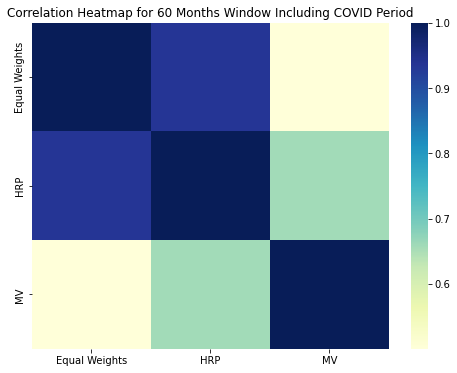

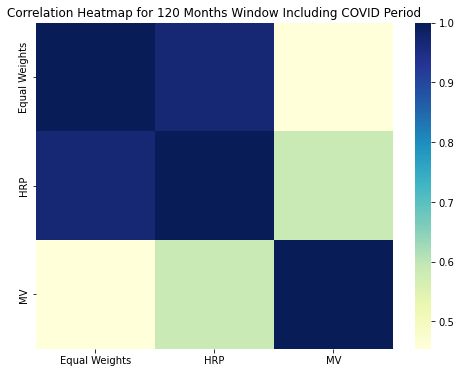

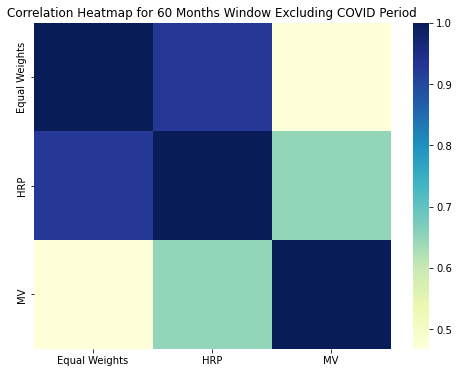

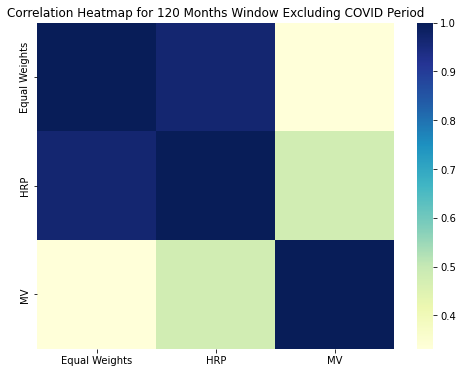

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `data_hrp` contains the four dataframes that you want to plot

for i, j in enumerate(data_hrp):
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(j.corr(), cmap="YlGnBu")
    if i == 0:
        plt.title("Correlation Heatmap for 60 Months Window Including COVID Period")
    elif i == 1:
        plt.title("Correlation Heatmap for 120 Months Window Including COVID Period")
    elif i == 2:
        plt.title("Correlation Heatmap for 60 Months Window Excluding COVID Period")
    else:
        plt.title("Correlation Heatmap for 120 Months Window Excluding COVID Period")
    plt.show()


#### Plotting the correlation heatmap to each pair of assets

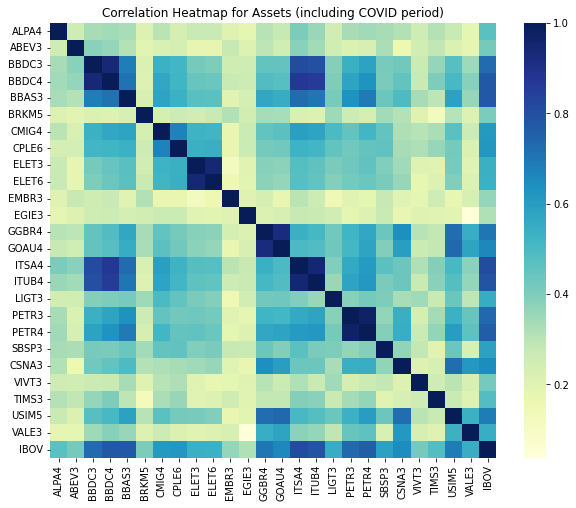

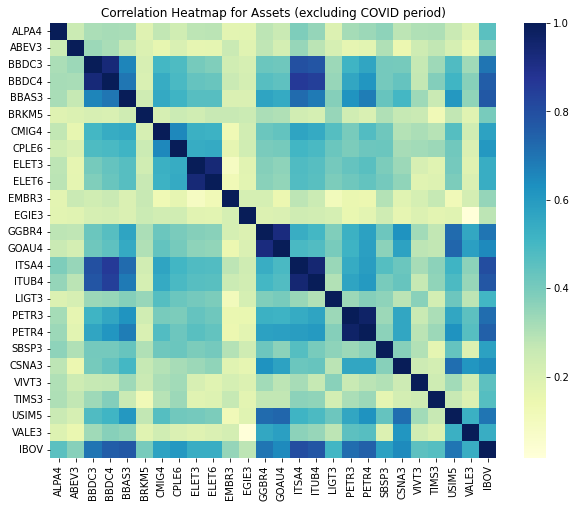

In [6]:
for i, j in enumerate(data):
    plt.figure(figsize=(10, 8))
    if j.equals(data[0]):
        plt.title(f"Correlation Heatmap for Assets (including COVID period)")
    else:
        plt.title(f"Correlation Heatmap for Assets (excluding COVID period)")
    ax = sns.heatmap(j.corr(), cmap="YlGnBu")
    plt.show()


In [7]:
for i, j in enumerate(data):
    if j.equals(data[0]):
        file_name = f"data\corr_matrix_including_covid.csv"
    else:
        file_name = f"data\corr_matrix_excluding_covid.csv"
        
    corr_matrix = j.corr()
    corr_matrix.to_csv(file_name)


#### More descriptive statistics to each asset. Note that the max column does not consider the comparison between the asset and itself

In [8]:
results_covid = pd.DataFrame()
results_wo_covid = pd.DataFrame()

for i, j in enumerate(data):
    if j.equals(data[0]):
        prefix = 'covid_'
    else:
        prefix = 'wo_covid_'
    
    corr_matrix = j.corr()
    results = pd.DataFrame(index=corr_matrix.index, columns=[f'{prefix}min', f'{prefix}max', f'{prefix}mean', f'{prefix}sd'])
    
    for asset in corr_matrix.columns:
        results.loc[asset, f'{prefix}min'] = corr_matrix[asset].min()
        results.loc[asset, f'{prefix}max'] = corr_matrix[asset][corr_matrix[asset] < 1].max()
        results.loc[asset, f'{prefix}mean'] = corr_matrix[asset].mean()
        results.loc[asset, f'{prefix}sd'] = corr_matrix[asset].std()
    
    if i == 0:
        results_covid = results
    else:
        results_wo_covid = results
    
results_concat = pd.concat([results_covid, results_wo_covid], axis=1)
results_concat


,covid_min,covid_max,covid_mean,covid_sd,wo_covid_min,wo_covid_max,wo_covid_mean,wo_covid_sd
ALPA4,0.180348,0.467619,0.320694,0.153167,0.170371,0.454753,0.309944,0.156106
ABEV3,0.159815,0.4144,0.29267,0.159986,0.146747,0.373675,0.264593,0.163197
BBDC3,0.217331,0.939455,0.498983,0.210811,0.212054,0.930972,0.477464,0.214255
BBDC4,0.210637,0.939455,0.521173,0.217712,0.207087,0.930972,0.504095,0.221847
BBAS3,0.197934,0.773849,0.511582,0.197521,0.20087,0.770689,0.501014,0.200654
BRKM5,0.126099,0.402946,0.286736,0.157884,0.121283,0.396867,0.274911,0.157905
CMIG4,0.174087,0.67136,0.457422,0.177649,0.130151,0.651366,0.431512,0.184449
CPLE6,0.174159,0.67136,0.439464,0.173666,0.165105,0.651366,0.421973,0.175769
ELET3,0.118086,0.94124,0.409911,0.205428,0.085753,0.938107,0.403645,0.210201
ELET6,0.153404,0.94124,0.406705,0.202997,0.121475,0.938107,0.402664,0.206967


In [9]:
results_concat.to_csv("data/basic_stats.csv")